# Baseball hitter's Salary Prediction
### Team 4 : Juna Lim,  Yoon Suk Lee, Gi Wook Lee
---
![Baseball](./Baseball_1.jpg )
___

## Why
---
![Baseball](./Ryu.jpg )
___

 - 류현진, KBO에서의 마지막 리그, 2012년 한화에서의 연봉은 4억 3천만원
   (Korean Baseball Player Hyun-Jin Ryu's, the last season's salary in Korean League, was 430 million won)
 - 스포츠에서는 어떻게 연봉이 책정될까?
   (How the salary of baseball player would be set?)
 - 정말 능력 위주로 연봉이 책정될까?
   (Is that Really set based on seasonal stats of baseball player?)

## Goal

 > **Feature** 야구 통계 사이트 statiz에 기재되어 있는 타자의 데이터를 기반으로(Based on annual hitter's statistics in statiz.co.kr)
 
 > **Target**  내년 연봉을 예측( predict a next season's annual salary)


## Preparation
 > **Data collection**
  - statiz 웹사이트에서 타자의 연봉(Y) 및 기록(X)를 크롤링(Crawled hitter's basic stats & salary information in statiz's website)
  
 > **Analysis Method**
  - Regression
   - 가중평균을 이용한 회귀분석(Regression by weighted average method)
   - PCA를 이용한 주성분 회귀분석(Principal component regression analysis by PCA)
---

## Task Plan

### 데이터수집 > 전처리 > 모델 선택 > 계수추정 > 평가 > 개선 > 최종 성능 평가
### Data Gathering > Preprocessing > model selection & tunning > Validation > Improvement > Final Performance Test



#### 1. 데이터(Data)
 - 데이터는 야구 선수 중 타자만을 대상으로 하였으며, 100타석 이상을 기준으로 데이터를 크롤링함.
 - Selected hitter's stats only, crawled player's stats whose annual batting attendances are greater than 100
 - 데이터는 **Real number**로 이루어져 있음.
 - All data is real number
 - 예) 타율 : 0.313, 타석 : 525, 연봉 2700 (단위 : 만원)
 - 데이터의 유효숫자는 최대 소수점 6자리로 하였으며, 7번째부터는 반올림으로 계산함. 

| X | Description | C/R | Class Label | Contraint |
| :---: | :--- | :---: | :---: | :---: |
| X0 | 타석, 타자가 타석에 선 수 | R | TASUK | X1>=0
| X1 | 타수, 타석 - 볼넷 - 데드볼 - 루타 - 희생타 | R |TASU | X1>=0
| X2 | 득점, 타자가 홈을 밟은 횟수 | R | DEUKJUM | X1>=0
| X3 | 안타, 아웃되지 않은 모든 진루타 | R | ANTA | X1>=0
| X4 | 2루타, 타격시 2루까지 가는 경우 | R | 2TA | X5>=0
| X5 | 3루타, 타격시 3루까지 가는 경우 | R | 3TA | X6>=0
| X6 | 홈런, 타격시 홈까지 가는 경우 | R | HOMERUN | X7>=0
| X7 | 루타, 단타 + 2루타\*2 + 3루타\*3 + 홈런\*4 | R | ALLTA | X8>=0
| X8 | 타점, 타자가 플레이해 주자가 득점 | R | TAJUM | X9 >=0
| X9 | 도루, 주자가 다음 베이스로 가는 경우 | R | DORU | X10 >=0
| X10 | 도루실패 | R | DOSIL | X11 >=0
| X11 | 희생타, 희생번트 + 희생플라이 | R | HEUITA | X12 >= 0
| X12 | 볼넷 | R | BALLNET | X13 >= 0
| X13 | 사사구, 몸에 맞은 공 | R | SAGU | X14 >= 0
| X14 | 고의사구, 상대 투수가 고의적으로 볼넷 | R | GOSA | X15 >= 0
| X15 | 삼진, 스트라이크 3번으로 아웃 | R | SAMJIN | X16 >= 0
| X16 | 병살, 한번의 타격으로 2아웃 되는 경우 | R | BYUNGSAL | X17>=0
| X17 | 타율, 한 게임 동안 친 안타의 평균 | R | TAYUL | X19>=0
| X18 | 출루율, 타자가 베이스로 나가는 평균율 | R | CHULRU | X20>=0
| X19 | 장타율, 타격시 멀리 가는 평균율 | R | JANGTA | X21>=0
| X20 | 경력, 프로야구 경력 | R | CAREER | X22>=0
| **Y** | **연봉** | R | **SALARY** | Y>=0


In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#X 및 Y list
k = 'TASUK,TASU,DEUKJUM,ANTA,2TA,3TA,HOMERUN,ALLTA,TAJUM,DORU,DOSIL,BALLNET,SAGU,GOSA,SAMJIN,BYUNGSAL,HEUITA,HEUIBI,TAYUL,CHULRU,JANGTA,CAREER,SALARY'
a = list(k.split(','))

#2015년 타자 데이터
df1 = pd.read_csv('salary_prediction_taja_add_career.csv')

df1.head()
dfX = pd.DataFrame(df1, columns = a[:-2])


# 희생타와 희생번트 병합 
dfX['HEUITA'] += dfX['HEUIBI']
del dfX['HEUIBI']
df_C = pd.DataFrame(df1, columns = ['CAREER'])
dfY = pd.DataFrame(df1, columns = ['SALARY'])

### 데이터 전처리
 - Scikit-Learn preprocessing패키지의 정규화(normalize) 사용

In [6]:
k1 = 'TASUK,TASU,DEUKJUM,ANTA,2TA,3TA,HOMERUN,ALLTA,TAJUM,DORU,DOSIL,BALLNET,SAGU,GOSA,SAMJIN,BYUNGSAL,HEUITA,TAYUL,CHULRU,JANGTA'
b = list(k1.split(','))

result = []
for i in b:
    result.append(normalize(dfX[i]).T)

#한 선수당 1 column인 data table    
db_batter_index = pd.DataFrame(np.hstack(result), columns = b)
db_batter_columns = db_batter_index.T
db_batter_index.head()

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int6

,TASUK,TASU,DEUKJUM,ANTA,2TA,3TA,HOMERUN,ALLTA,TAJUM,DORU,DOSIL,BALLNET,SAGU,GOSA,SAMJIN,BYUNGSAL,HEUITA,TAYUL,CHULRU,JANGTA
0,0.144593,0.132288,0.216451,0.166232,0.204269,0.209795,0.325714,0.218952,0.233605,0.278356,0.164226,0.239674,0.177220,0.389885,0.125696,0.076372,0.076886,0.140532,0.144986,0.184098
1,0.137546,0.139295,0.126541,0.127445,0.199405,0.167836,0.076231,0.129141,0.093442,0.173972,0.205282,0.137289,0.054529,0.035444,0.167134,0.021820,0.065902,0.102540,0.103936,0.103235
2,0.145322,0.145742,0.171496,0.173620,0.204269,0.041959,0.159392,0.176688,0.193558,0.020877,0.061585,0.155904,0.027265,0.070888,0.098071,0.141833,0.098853,0.133524,0.125480,0.134927
3,0.135845,0.125562,0.149851,0.132986,0.121589,0.000000,0.180182,0.144990,0.193558,0.020877,0.000000,0.193135,0.259013,0.000000,0.133984,0.141833,0.098853,0.118401,0.128391,0.128403
4,0.141434,0.143219,0.148186,0.136680,0.170224,0.209795,0.131672,0.146751,0.121808,0.153096,0.082113,0.130308,0.068161,0.070888,0.158847,0.109102,0.109837,0.106966,0.105391,0.113954


In [7]:
# 상관계수
corr_data = pd.DataFrame.corr(db_batter_index)
corr_data.head()

,TASUK,TASU,DEUKJUM,ANTA,2TA,3TA,HOMERUN,ALLTA,TAJUM,DORU,DOSIL,BALLNET,SAGU,GOSA,SAMJIN,BYUNGSAL,HEUITA,TAYUL,CHULRU,JANGTA
TASUK,1.000000,0.994119,0.885191,0.967224,0.835030,0.458631,0.480524,0.908842,0.749047,0.446213,0.524139,0.748908,0.364117,0.390433,0.667262,0.602686,0.465027,0.501351,0.411021,0.281078
TASU,0.994119,1.000000,0.877536,0.970647,0.836924,0.461281,0.453554,0.900706,0.731281,0.449758,0.539666,0.680318,0.335967,0.351069,0.660568,0.595233,0.462446,0.499988,0.352268,0.253717
DEUKJUM,0.885191,0.877536,1.000000,0.913815,0.854583,0.599118,0.483254,0.887466,0.683259,0.600686,0.622123,0.697994,0.334309,0.365996,0.590731,0.399756,0.320801,0.605706,0.532118,0.423060
ANTA,0.967224,0.970647,0.913815,1.000000,0.861973,0.447916,0.495649,0.937619,0.769909,0.438309,0.518970,0.691171,0.312810,0.417304,0.580029,0.573772,0.401995,0.675693,0.511450,0.385033
2TA,0.835030,0.836924,0.854583,0.861973,1.000000,0.390232,0.536768,0.884852,0.733055,0.391536,0.494273,0.619931,0.272567,0.400995,0.549139,0.439291,0.281045,0.573360,0.457486,0.478281


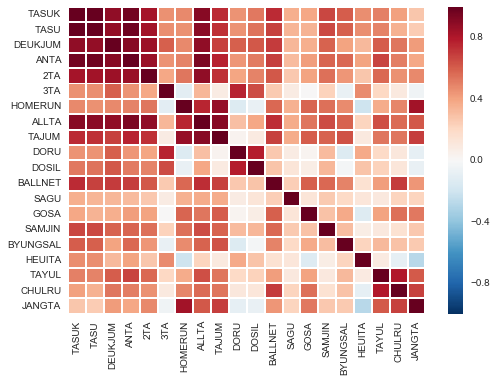

In [8]:
import seaborn as sns
sns.heatmap(corr_data, annot=False, linewidths=1)
plt.show()


## 가중평균을 이용한 회귀분석

### 상관계수 그룹화

#### 위의 Heatmap에서 상관계수가 높은 X 변수들끼리 그룹화한후 가중평균

In [9]:
group1 = (db_batter_index['TASUK'] + db_batter_index['TASU'] + db_batter_index['DEUKJUM'] + db_batter_index['ANTA'] \
           + db_batter_index['2TA'] + db_batter_index['HOMERUN'] + db_batter_index['ALLTA'] + db_batter_index['TAJUM'] \
           + db_batter_index['BALLNET'] + db_batter_index['SAMJIN'] + db_batter_index['BYUNGSAL'] + db_batter_index['HEUITA'] \
           + db_batter_index['TAYUL'] + db_batter_index['CHULRU'] + db_batter_index['JANGTA'])/15
group2 = (db_batter_index['3TA'] + db_batter_index['SAGU'])/2
group3 = (db_batter_index['DORU'] + db_batter_index['GOSA'])/2
group4 = db_batter_index['DOSIL']

In [10]:
#가중평균점수
score = pd.concat([group1, group2, group3, group4], axis = 1)
score.columns = ['Attack', 'Strength', 'Mobility', 'Missing']

In [11]:
df_career = pd.DataFrame(np.log(df_C['CAREER']+1).T, columns = ['CAREER'])
salary_prediction_w = pd.concat([score, df_career, np.log(dfY)], axis = 1)
salary_prediction_w.head()

,Attack,Strength,Mobility,Missing,CAREER,SALARY
0,0.175357,0.193507,0.334120,0.164226,0.693147,11.736069
1,0.115393,0.111183,0.104708,0.205282,1.945910,10.126631
2,0.150579,0.034612,0.045882,0.061585,2.397895,11.002100
3,0.141837,0.129507,0.010438,0.000000,2.484907,11.225243
4,0.131625,0.138978,0.111992,0.082113,0.693147,9.680344


In [12]:
regression_w = 'SALARY ~ np.log(Attack) + Mobility + Missing + CAREER'
model_salary_w = sm.OLS.from_formula(regression_w, data = salary_prediction_w)
result_salary_w = model_salary_w.fit()
print (result_salary_w.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     37.29
Date:                Tue, 20 Dec 2016   Prob (F-statistic):           1.41e-17
Time:                        13:49:04   Log-Likelihood:                -72.288
No. Observations:                  85   AIC:                             154.6
Df Residuals:                      80   BIC:                             166.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         13.1855      0.706     18.

- Cross Validation에서는 평균 r2 score가 0.5를 기록해 다른 모델을 선택

## PCA를 이용한 주성분 회귀분석

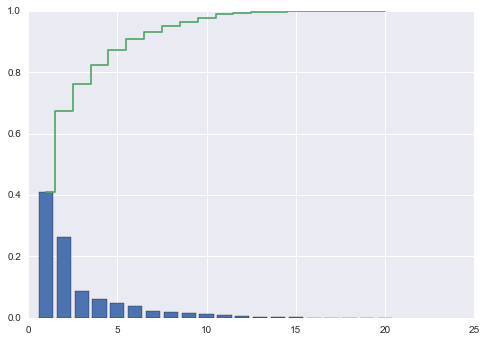

In [13]:
# 주성분 분석을 위한 변수 범위 설정, X feature 3개로 했을 때 분산 설명력 76%

pca = PCA().fit(db_batter_index)
var = pca.explained_variance_
cmap = sns.color_palette()

plt.bar(np.arange(1,len(var)+1), var/np.sum(var), align="center", color=cmap[0])
plt.step(np.arange(1,len(var)+1), np.cumsum(var)/np.sum(var), where="mid", color=cmap[1])
plt.show()

In [14]:
#PCA setting
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(db_batter_index)
#How many PCA do I need to use?
k = pca.explained_variance_ratio_
sum = k[0] + k[1] + k[2]
print k
print '='*20

print 'Average :' + str(sum)

[ 0.41000883  0.26295137  0.08885089  0.06256719  0.04804775]
Average :0.761811088576


In [15]:
# PCA 성분 개수

X_pca = PCA(n_components=3)
X_pca.fit_transform(db_batter_index)

# PCA화된 변수 DataFrame 생성
dfX_pca = pd.DataFrame(X_pca.fit_transform(db_batter_index))
dfX_pca.columns = ['PC1', 'PC2', 'PC3']

# PCA + 선수경력 + y값(연봉) 병합 DataFrame생성
df_pca_analysis = pd.concat([dfX_pca, pd.DataFrame(normalize(df_C['CAREER']).T), np.log(dfY)], axis = 1)
df_pca_analysis.columns = ['PC1', 'PC2', 'PC3', 'CAREER', 'SALARY']
#dfX_pca

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [16]:
# statsmodels OLS 모델의 R-stle formula를 사용하여 Linear Regression 실행 

regression = 'SALARY ~ PC1 + PC2 + I(PC3 ** 2) + CAREER'
model_salary = sm.OLS.from_formula(regression, data = df_pca_analysis)
result_salary = model_salary.fit()
print (result_salary.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     42.64
Date:                Tue, 20 Dec 2016   Prob (F-statistic):           4.15e-19
Time:                        13:57:06   Log-Likelihood:                -68.492
No. Observations:                  85   AIC:                             147.0
Df Residuals:                      80   BIC:                             159.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       9.4212      0.137     68.812      

# 레버리지 및 아웃라이어

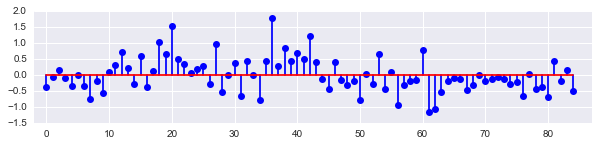

In [17]:
plt.figure(figsize=(10, 2))
plt.stem(result_salary.resid)
plt.xlim([-2, len(dfY)+2])
plt.show()

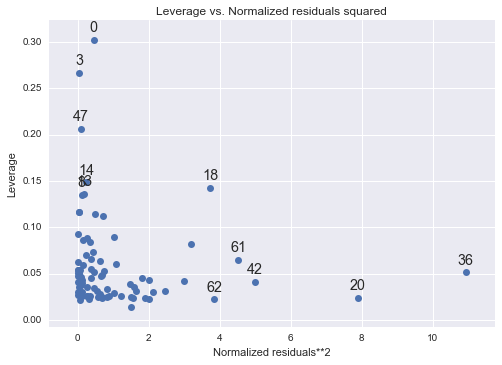

In [18]:
sm.graphics.plot_leverage_resid2(result_salary)
plt.show()

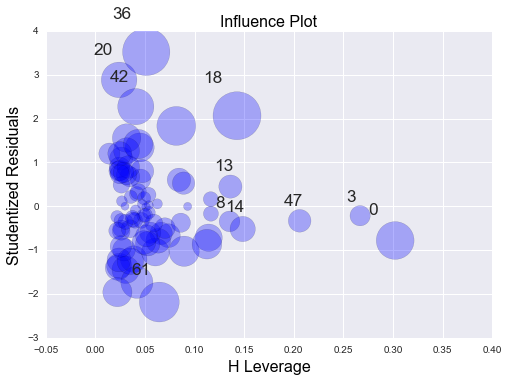

In [19]:
# Data index에 따른 Leverage 및 오차 정도 시각화 (X-axis = Leverage, Y-axis = Student-t분포를 따르는 잔차(오차의 크기)

sm.graphics.influence_plot(result_salary, plot_alpha=0.3)
plt.show()

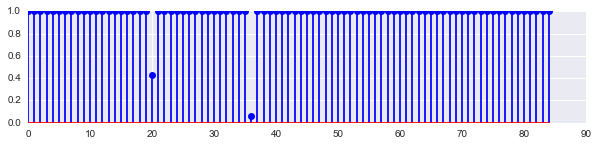

In [20]:
# Data index에 따른 outliar 판별 test

plt.figure(figsize=(10, 2))
plt.stem(result_salary.outlier_test().ix[:, -1])
plt.show()

## 아웃라이어 제거

In [21]:
# 위 20, 36번 index의 데이터 제거

df_pca_analysis2 = df_pca_analysis.drop(36)
df_pca_analysis3 = df_pca_analysis2.drop(20)

In [22]:
#아웃라이어 제거 후 OLS
regression = 'SALARY ~ PC1 + PC2 + I(PC3 ** 2) + CAREER'
model_salary = sm.OLS.from_formula(regression, data = df_pca_analysis3)
result_salary = model_salary.fit()
print (result_salary.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     57.36
Date:                Tue, 20 Dec 2016   Prob (F-statistic):           1.76e-22
Time:                        13:59:00   Log-Likelihood:                -56.811
No. Observations:                  83   AIC:                             123.6
Df Residuals:                      78   BIC:                             135.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       9.3014      0.124     74.814      

## Cross Validation
 - Label K Fold 사용
 - Cross Validation 하기 전에 outlier를 제거한 index를 Median으로 채움

In [23]:
# outlier index의 null값 median으로 imputing

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
pca_analysis4 = imp.fit_transform(df_pca_analysis3)

df_pca_analysis5 = pd.DataFrame(pca_analysis4, columns = ['PC1', 'PC2', 'PC3', 'CAREER', 'SALARY'])

In [24]:
# cv용 x, y 데이터 분리

df_pca_analysis_cv_x = pd.DataFrame(df_pca_analysis5, columns = ['PC1', 'PC2', 'PC3', 'CAREER'])
df_pca_analysis_cv_y = pd.DataFrame(df_pca_analysis5, columns = ['SALARY'])
X = df_pca_analysis_cv_x.ix[:]

In [25]:
# Label-KFold 방법으로 CrossValidation 진행

from sklearn.cross_validation import LabelKFold
cv = LabelKFold(df_pca_analysis_cv_y['SALARY'], n_folds=3)

# train, test index에 따른 y값 확인
for train_index, test_index in cv:
    print("test  y:\n", df_pca_analysis_cv_y['SALARY'][test_index])
    print("." * 80 )        
    print("train y:\n", df_pca_analysis_cv_y['SALARY'][train_index])
    print("=" * 80 )

('test  y:\n', 1     10.126631
5     10.645425
6     10.308953
8      9.852194
9      8.987197
10    11.982929
17    10.819778
23    10.819778
25     9.952278
26    11.407565
28    11.082143
29    10.341742
31    10.308953
39     9.952278
41    10.819778
44    10.819778
46     9.392662
53    10.819778
58    10.819778
60     8.779557
63    10.308953
65     9.392662
68     8.999619
69     8.987197
73     8.517193
77     9.392662
78     8.517193
79    10.126631
Name: SALARY, dtype: float64)
................................................................................
('train y:\n', 0     11.736069
2     11.002100
3     11.225243
4      9.680344
7     10.043249
11    11.156251
12    11.512925
13    11.264464
14     9.615805
15    11.156251
16    11.156251
18    11.225243
19    11.002100
20     9.903488
21    10.621327
22    10.463103
24    11.512925
27    10.596635
30     9.903488
32     9.769956
33     9.825526
34    10.714418
35    10.596635
36    10.915088
37    10.165852
38    11.28

In [34]:
# Scikit-Learn LinearRegression 사용한 선형회귀 및 성능 평가(R2 스코어 사용)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()

scores = np.zeros(3)


# cv에 따라 train set, test set 분리 후 cv 진행
for i, (train_index, test_index) in enumerate(cv):
    X_train = df_pca_analysis_cv_x.ix[train_index]
    y_train = df_pca_analysis_cv_y['SALARY'][train_index]
    X_test = df_pca_analysis_cv_x.ix[test_index]
    y_test = df_pca_analysis_cv_y['SALARY'][test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #scores[i] = mean_squared_error(y_test, y_pred)
    scores[i] = r2_score(y_test, y_pred)

print scores
np.mean(scores)

[ 0.7406085   0.8038      0.58386846]


0.70942565168737903

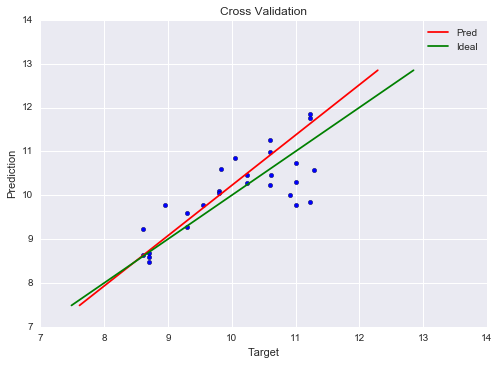

In [33]:
# Test 결과 y_pred와 y 실제값 모형 비교

plt.scatter(y_test, y_pred)
plt.title('Cross Validation')
plt.ylabel('Prediction')
plt.xlabel('Target')
xx = np.linspace(np.min(y_test) - 1, np.max(y_test) + 1, 1000)
yy = np.linspace(np.min(y_pred) - 1, np.max(y_pred) + 1, 1000)
plt.plot(xx, yy, 'r-', label='Pred')
plt.plot(yy, yy, 'g-', label='Ideal')
plt.legend()
plt.show()

## Conclusion & limitations
    - 예측 스코어 70점 결과 도출
    1. 전체선수 약 230명 중 타석 100타석 이상인 선수들 105명으로 Data Set이 부족한 영향
    2. 선수 경기력 이외에 나이, 포지션 등 영향을 끼치는 변수가 더 있을 것으로 생각됨.
    3. 야구선수 중 경력 7년 이후 FA 재계약 후 연봉이 급등하는 경우가 많아 이점이 고려되지 않았음
    4. 20번, 36번 Data를 확인하지 않고 Outlier로 판단해 제거 실시 ⇒ 실제 Data를 확인하여 검증 필요